# Load packages

In [1]:
%load_ext autoreload
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Concatenate, Input

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sn

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Define

## vars

In [1]:
fusionPath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/fusion/embedDrug_embedRNA_V2/models'


## funcs

In [5]:
def countDrugsK(df, k=1):
    drugCount = {}
    wrong = []
    for cell, subdf in df.groupby(by='cell_line'):
        sortDF = subdf.sort_values(by='pred', ascending=False).reset_index(drop=True)
        drugs = sortDF.loc[:k-1, 'drug']
        for drug in drugs:
            if drug in drugCount.keys():
                drugCount[drug] += 1
            else:
                drugCount[drug] = 1
        drug = drugs[0]

        if sortDF.iloc[:k, :].true.sum() == 0:
            wrong.append(cell)
            print(f"\nNo true effective drugs identified in top {k} for {cell}")
            print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}\n")
        else:
            print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}")
    return drugCount, wrong

# Data

## Load cell lines

In [6]:
trainRNA = pd.read_csv('../data/cell_lines/RNA_train_cancergenes_updatedSplit.csv', index_col=0)
trainCellLines = list(trainRNA.index)

testRNA = pd.read_csv('../data/cell_lines/RNA_test_cancergenes_updatedSplit.csv', index_col=0)
testCellLines = list(testRNA.index)

newRNA = pd.read_csv('../data/cell_lines/RNA_newcancer_cancergenes_updatedSplit.csv', index_col=0)
newCellLines = list(newRNA.index)

## CDR

In [7]:
cdr = pd.read_csv('../data/drug_response/prismProcessed3.csv', index_col='DepMap_ID')
trainCDR = cdr.loc[trainCellLines, :].reset_index()
testCDR = cdr.loc[testCellLines, :].reset_index()
newCDR = cdr.loc[newCellLines, :].reset_index()

In [8]:
testCDR.head()

,DepMap_ID,cancer_type,name,moa,target,indication,phase,r2,ic50,auc,lower_limit,effectiveCont,effective
0,ACH-000961,Endometrial/Uterine Cancer,floxuridine,DNA synthesis inhibitor,TYMS,colorectal cancer,Launched,0.822527,0.039417,0.629954,0.391400,3.999535,0
1,ACH-000961,Endometrial/Uterine Cancer,valrubicin,"DNA inhibitor, topoisomerase inhibitor",TOP2A,bladder cancer,Launched,0.899770,0.218469,0.605413,0.000926,8.121360,1
2,ACH-000961,Endometrial/Uterine Cancer,romidepsin,HDAC inhibitor,"HDAC1, HDAC2, HDAC3, HDAC4, HDAC5, HDAC6, HDAC...",cutaneous T-cell lymphoma (CTCL),Launched,0.709292,0.007056,0.252551,0.000448,12.000541,1
3,ACH-000961,Endometrial/Uterine Cancer,AZD3463,"ALK tyrosine kinase receptor inhibitor, insuli...","ALK, IGF1R",NaN,Preclinical,0.726827,0.352112,0.653865,0.002481,6.782965,0
4,ACH-000961,Endometrial/Uterine Cancer,cycloheximide,protein synthesis inhibitor,RPL3,NaN,Preclinical,0.823164,0.543942,0.681261,0.015422,4.687175,0


In [9]:
testTemp = testCDR.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'effective']].rename(columns={'DepMap_ID':'cell_line',
                                                                                             'name': 'drug',
                                                                                             'effective': 'true'})

newTemp = newCDR.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'effective']].rename(columns={'DepMap_ID':'cell_line',
                                                                                          'name': 'drug',
                                                                                          'effective': 'true'})

# Load drugs

In [10]:
drugs = pd.read_csv('../data/drug_response/drug_fingerprints.csv', index_col=0)

drugs.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
cytarabine,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
epinastine,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
floxuridine,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
valrubicin,1,0,0,0,0,1,0,0,1,0,...,0,1,0,1,1,1,0,1,0,0
adapalene,1,1,1,0,0,1,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0


In [11]:
trainDrugs = drugs.loc[list(trainCDR.name.values), :].to_numpy()
testDrugs = drugs.loc[list(testCDR.name.values), :].to_numpy()
newDrugs = drugs.loc[list(newCDR.name.values), :].to_numpy()

trainRNA = trainRNA.loc[list(trainCDR.DepMap_ID.values), :].to_numpy()
testRNA = testRNA.loc[list(testCDR.DepMap_ID.values), :].to_numpy()
newRNA = newRNA.loc[list(newCDR.DepMap_ID.values), :].to_numpy()

In [12]:
trainData = [trainDrugs, trainRNA]
trainEff = trainCDR.effective.to_numpy()
testData = [testDrugs, testRNA]
newData = [newDrugs, newRNA]

In [13]:
del cdr, drugs, trainDrugs, testDrugs, newDrugs, trainRNA, testRNA, newRNA

# Encoders

In [14]:
def loadEncoder(path, which='rna'):
    snn = load_model(path)
    encoder = snn.get_layer('model')
    encoder._name = f'{which}Encoder'
    return encoder

## Load best cell line encoder

In [15]:
basePath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/cellLines/siameseV1/'
modelDir = os.path.join(basePath, 'models')
bestRNA = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFsigmoid_LR0-001_DR0-99_DS1000'
bestRNAPath = os.path.join(modelDir, bestRNA)

rnaEncoder = loadEncoder(bestRNAPath)

In [16]:
rnaEncoder.summary()

Model: "rnaEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 463)]             0         
                                                                 
 dense (Dense)               (None, 64)                29696     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 33,856
Trainable params: 33,856
Non-trainable params: 0
_________________________________________________________________


# Load drug encoder

In [17]:
basePath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/drugs/siameseV1/'
modelDir = os.path.join(basePath, 'models')
bestDrug = 'DrugFewShot_Layers1_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
bestDrugPath = os.path.join(modelDir, bestDrug)

drugEncoder = loadEncoder(bestDrugPath, 'drug')

In [113]:
drugEncoder.summary()

Model: "drugEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 20,608
Trainable params: 20,608
Non-trainable params: 0
_________________________________________________________________


# Get fusion encoder func

In [170]:
def triplet_loss(y_true, y_pred, alpha=0.1):
    anchor, positive, negative = y_pred[:, :8],\
                                 y_pred[:, 8:2*8],\
                                 y_pred[:, 2*8:]
    posDist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negDist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(posDist - negDist + alpha, 0.)


def getEncoder(path=None, encodeDrug='embed', encodeRNA='embed', drugInDim=256, rnaInDim=463):
    # Define encoded drug input
    drugInput = Input(drugInDim)
    if encodeDrug == 'embed':
        drugEmbed = drugEncoder(drugInput)
    else:
        drugEmbed = drugInput
    
    # Define encoded rna input
    rnaInput = Input(rnaInDim)
    if encodeRNA == 'embed':
        rnaEmbed = rnaEncoder(rnaInput)
    else:
        rnaEmbed = rnaInput
        
    
    # combine drug + rna input
    pairEmbed = Concatenate()([drugEmbed, rnaEmbed])
    
    # Add fusion model if desired

    if path != None:
        fusionEncoder = load_model(path, custom_objects={'triplet_loss':triplet_loss})
        fusionEncoder = fusionEncoder.get_layer('model')

        pairEmbed = fusionEncoder(pairEmbed)
    
    return Model(inputs=[drugInput, rnaInput], outputs=pairEmbed)

In [233]:
def clPrecision(preds, modelName=None, thresh=0.6, getResults=False, verbose=True):
    p1 = []
    p2 = []
    p3 = []
    p4 = []
    p5 = []
    p0 = []
    cellLines = []
    for cell, subdf in preds.groupby(by='cell_line'):
        nEff = subdf.true.sum()
        if nEff < 5:
            continue
            
        cellLines.append(cell)
        sortDF = subdf.sort_values(by='pred', ascending=False)
        p1.append(sortDF.iloc[:1, :].true.sum() / 1)
        p2.append(sortDF.iloc[:2, :].true.sum() / 2)
        p3.append(sortDF.iloc[:3, :].true.sum() / 3)
        p4.append(sortDF.iloc[:4, :].true.sum() / 4)
        p5.append(sortDF.iloc[:5, :].true.sum() / 5)
        if nEff >= 10:
            p0.append(sortDF.iloc[:10, :].true.sum() / 10)
            
    if np.mean(p5) >= thresh:
        if verbose:
            thresh = np.mean(p5)
            print(f"Model: {modelName}")
            print(f"\tPrecision@1: {round(np.mean(p5), 4)}")
            print(f"\tPrecision@2: {round(np.mean(p2), 4)}")
            print(f"\tPrecision@3: {round(np.mean(p3), 4)}")
            print(f"\tPrecision@4: {round(np.mean(p4), 4)}")
            print(f"\tPrecision@5: {round(np.mean(p5), 4)}")
            print(f"\tPrecision@10: {round(np.mean(p0), 4)}\n\n")
        
    if getResults:
        return [np.mean(p1), np.mean(p2), np.mean(p3), np.mean(p4), np.mean(p5)]
    
    if verbose:
        return thresh
    
    
def precision(preds, modelName, thresh, by='cellLine'):
    if by == 'cellLine':
        return clPrecision(preds, modelName, thresh=thresh)
    else:
        cancers = {}
        for ct, subdf in preds.groupby(by = 'cancer_type'):
            cancers[ct] = clPrecision(subdf, verbose=False, getResults=True)
        return pd.DataFrame(cancers, index=['p1', 'p2', 'p3', 'p4', 'p5']).T


def getPreds(trainData, trainEff, testData,
             modelPath=None, encodeDrug=True, encodeRNA=True):
    
    # Load encoder
    if (modelPath != None):
        encoder = getEncoder(path=modelPath, encodeDrug=encodeDrug, encodeRNA=encodeRNA)
    else:
        encoder = getEncoder(encodeDrug=encodeDrug, encodeRNA=encodeRNA)
        
    # Encode pairs
    trainEmbed = encoder(trainData)
    testEmbed = encoder(testData)

    # Create logisitic regression model
    lm = LogisticRegression().fit(trainEmbed, trainEff)

    # predict
    return [p[1] for p in lm.predict_proba(testEmbed)]
        
        
def iterateModels(trainData, trainEff, testData, predDF,
                  thresh=0.5, modelName=None, k=1, by='cellLine', drug='embed', rna='embed', fusion=True):
    if (modelName != None):
        # get preds
        if fusion:
            modelPath = os.path.join(fusionPath, modelName)
        else: 
            modelPath = None
        preds = getPreds(trainData, trainEff, testData, 
                         modelPath=modelPath, encodeDrug=drug, encodeRNA=rna)
        predDF['pred'] = preds
        
        predDF.sort_values(by='pred', ascending=False, inplace=True)
        if by == 'cellLine':
            print('Average Cell Line precision @ k')
            precision(predDF, modelName, thresh, by)
            
            print("Top ranked drug for each cell line:")
            counts, wrong = countDrugsK(predDF, k)
            
            print(f"\n# cell lines without highly effective drug among top-{k} predictions: {len(wrong)}")
            
            print(f"\n# of times each drug recommended in top-{k}:")
            counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)
            for drug, cnt in counts:
                print(f"{drug}: {cnt}")
                
            return predDF, wrong
        
        else:
            df = precision(predDF, modelName, thresh, by)
            df.sort_values(by=['p1','p1','p3','p4','p5'], ascending=False, inplace=True)
            return df
        
    else:
        files = [f for f in os.listdir(fusionPath) if 'BYrna' in f]
        for f in files:
            if fusion:
                modelPath = os.path.join(fusionPath, f)
                preds = getPreds(trainData, trainEff, testData,
                                 modelPath=modelPath, encodeDrug=drug, encodeRNA=rna)
            else:
                preds = getPreds(trainData, trainEff, testData,
                                 encodeDrug=drug, encodeRNA=rna)
            predDF['pred'] = preds
            thresh = precision(predDF.copy(), f, thresh, by)
            if not fusion:
                break
            
        print(thresh)

# Fusion performance

## Test set 

In [223]:
iterateModels(trainData, trainEff, testData, testTemp.copy(),
              thresh=0.75, by='cellLine', drug='embed', rna='embed', fusion=True)

Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.7647
	Precision@2: 0.7745
	Precision@3: 0.7778
	Precision@4: 0.7745
	Precision@5: 0.7882
	Precision@10: 0.7923


0.7647058823529411


In [224]:
best = 'FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna'

### Precision by cell line and top-3 predictions for best model

In [225]:
fusedTestPred, fusedTestWrong  = iterateModels(trainData, trainEff, testData, testTemp.copy(), 
                                        modelName=best, k=3, by='cellLine', drug='embed', rna='embed', fusion=True)

Average Cell Line precision @ k
Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.7647
	Precision@2: 0.7745
	Precision@3: 0.7778
	Precision@4: 0.7745
	Precision@5: 0.7882
	Precision@10: 0.7923


Top ranked drug for each cell line:
Cell line: ACH-000012; Top drug: genz-644282
Cell line: ACH-000062; Top drug: romidepsin
Cell line: ACH-000086; Top drug: YM-155

No true effective drugs identified in top 3 for ACH-000161
Cell line: ACH-000161; Top drug: echinomycin

Cell line: ACH-000164; Top drug: genz-644282
Cell line: ACH-000222; Top drug: camptothecin
Cell line: ACH-000280; Top drug: GZD824
Cell line: ACH-000305; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000316; Top drug: bruceantin
Cell line: ACH-000320; Top drug: alvespimycin
Cell line: ACH-000329; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000347; Top drug: romidepsin
Cell line: ACH-000368; Top drug: verubulin
Cell line: ACH-000376; Top drug: sangivamycin
Cell line: ACH-000421; 

In [226]:
fusedTestWrong

['ACH-000161', 'ACH-000750']

In [228]:
fusedTestPred[fusedTestPred.cell_line == 'ACH-000161'].head(10)

,cell_line,cancer_type,drug,true,pred
6301,ACH-000161,Lung Cancer,echinomycin,0,0.810681
6235,ACH-000161,Lung Cancer,cabazitaxel,0,0.807362
6237,ACH-000161,Lung Cancer,genz-644282,0,0.797310
6288,ACH-000161,Lung Cancer,dolastatin-10,1,0.796758
6296,ACH-000161,Lung Cancer,10-hydroxycamptothecin,1,0.796732
6231,ACH-000161,Lung Cancer,RITA,1,0.773266
6274,ACH-000161,Lung Cancer,YM-155,1,0.766606
6262,ACH-000161,Lung Cancer,JNJ-26481585,0,0.745375
6259,ACH-000161,Lung Cancer,sangivamycin,1,0.731357
6284,ACH-000161,Lung Cancer,gemcitabine,1,0.719159


In [230]:
fusedTestPred[fusedTestPred.cell_line == 'ACH-000750'].head(10)

,cell_line,cancer_type,drug,true,pred
4087,ACH-000750,Skin Cancer,camptothecin,0,0.821160
4198,ACH-000750,Skin Cancer,alvespimycin,0,0.802244
4082,ACH-000750,Skin Cancer,gemcitabine,0,0.795641
4093,ACH-000750,Skin Cancer,dolastatin-10,1,0.773673
4066,ACH-000750,Skin Cancer,YM-155,1,0.768075
4048,ACH-000750,Skin Cancer,genz-644282,1,0.758633
4130,ACH-000750,Skin Cancer,echinomycin,1,0.754948
4111,ACH-000750,Skin Cancer,10-hydroxycamptothecin,1,0.754500
4137,ACH-000750,Skin Cancer,nemorubicin,1,0.719455
4096,ACH-000750,Skin Cancer,OTS167,1,0.500505


### precision by cancer

In [237]:
cancerFusedTest = iterateModels(trainData, trainEff, testData, testTemp.copy(), 
                                  modelName=best, k=3, by='cancer', drug='embed', rna='embed', fusion=True)

In [238]:
cancerFusedTest

,p1,p2,p3,p4,p5
Bladder Cancer,1.000000,1.000000,1.000000,1.000000,1.000000
Head and Neck Cancer,1.000000,1.000000,1.000000,0.916667,0.866667
Ovarian Cancer,1.000000,1.000000,1.000000,0.875000,0.800000
Endometrial/Uterine Cancer,1.000000,1.000000,0.888889,0.833333,0.800000
Colon/Colorectal Cancer,1.000000,0.875000,0.833333,0.875000,0.900000
Pancreatic Cancer,1.000000,0.875000,0.833333,0.750000,0.800000
Esophageal Cancer,1.000000,0.666667,0.777778,0.833333,0.733333
Skin Cancer,0.800000,0.800000,0.666667,0.700000,0.760000
Lung Cancer,0.538462,0.730769,0.717949,0.711538,0.769231
Liver Cancer,0.500000,0.500000,0.666667,0.750000,0.700000


In [266]:
print('Number of cell lines per cancer type in training data')
trainCDR.loc[:, ['DepMap_ID', 'cancer_type']].drop_duplicates(keep='first').cancer_type.value_counts()

Number of cell lines per cancer type in training data


Lung Cancer                   63
Skin Cancer                   25
Brain Cancer                  23
Pancreatic Cancer             21
Ovarian Cancer                21
Colon/Colorectal Cancer       17
Esophageal Cancer             15
Endometrial/Uterine Cancer    14
Head and Neck Cancer          14
Bladder Cancer                14
Breast Cancer                 13
Liver Cancer                  11
Name: cancer_type, dtype: int64

In [265]:
print('Number of cell lines per cancer type in test data')
fusedTestPred.loc[:, ['cell_line', 'cancer_type']].drop_duplicates(keep='first').cancer_type.value_counts()


Number of cell lines per cancer type in test data


Lung Cancer                   13
Skin Cancer                    5
Brain Cancer                   5
Ovarian Cancer                 4
Pancreatic Cancer              4
Colon/Colorectal Cancer        4
Breast Cancer                  3
Bladder Cancer                 3
Esophageal Cancer              3
Head and Neck Cancer           3
Endometrial/Uterine Cancer     3
Liver Cancer                   2
Name: cancer_type, dtype: int64

## New cancer set 

### Precision by cell line and top-3 predictions

In [244]:
fusedNewPred, fusedNewWrong  = iterateModels(trainData, trainEff, newData, newTemp.copy(), 
                                        modelName=best, k=3, by='cellLine', drug='embed', rna='embed', fusion=True)

Average Cell Line precision @ k
Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.8154
	Precision@2: 0.7769
	Precision@3: 0.7897
	Precision@4: 0.7885
	Precision@5: 0.7846
	Precision@10: 0.7941


Top ranked drug for each cell line:
Cell line: ACH-000037; Top drug: echinomycin
Cell line: ACH-000046; Top drug: GZD824
Cell line: ACH-000052; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000054; Top drug: echinomycin
Cell line: ACH-000087; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000090; Top drug: cabazitaxel
Cell line: ACH-000096; Top drug: triptolide
Cell line: ACH-000099; Top drug: maytansinol-isobutyrate
Cell line: ACH-000141; Top drug: maytansinol-isobutyrate
Cell line: ACH-000159; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000169; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000171; Top drug: maytansinol-isobutyrate
Cell line: ACH-000172; Top drug: maytansinol-isobutyrate
Cell line: ACH-000174; Top drug: maytansinol-isobutyr

In [245]:
fusedNewWrong

['ACH-000268', 'ACH-000428']

In [248]:
fusedNewPred[fusedNewPred.cell_line == 'ACH-000268'].head(10)

,cell_line,cancer_type,drug,true,pred
9846,ACH-000268,Bile Duct Cancer,verubulin,0,0.719711
9832,ACH-000268,Bile Duct Cancer,sangivamycin,0,0.700130
9834,ACH-000268,Bile Duct Cancer,epothilone-d,0,0.507877
9844,ACH-000268,Bile Duct Cancer,rubitecan,0,0.433175
9839,ACH-000268,Bile Duct Cancer,BGT226,0,0.328325
9836,ACH-000268,Bile Duct Cancer,SB-939,0,0.104504
9835,ACH-000268,Bile Duct Cancer,delanzomib,0,0.066189
9843,ACH-000268,Bile Duct Cancer,LY2606368,0,0.044299
9838,ACH-000268,Bile Duct Cancer,GSK2126458,0,0.024082
9837,ACH-000268,Bile Duct Cancer,alvocidib,0,0.014727


In [249]:
fusedNewPred[fusedNewPred.cell_line == 'ACH-000428'].head(10)

,cell_line,cancer_type,drug,true,pred
9707,ACH-000428,Kidney Cancer,JNJ-26481585,0,0.820004
9744,ACH-000428,Kidney Cancer,echinomycin,0,0.795698
9692,ACH-000428,Kidney Cancer,cabazitaxel,0,0.790149
9717,ACH-000428,Kidney Cancer,YM-155,1,0.785368
9737,ACH-000428,Kidney Cancer,10-hydroxycamptothecin,1,0.760326
9724,ACH-000428,Kidney Cancer,alvespimycin,0,0.740871
9729,ACH-000428,Kidney Cancer,OTS167,0,0.477448
9711,ACH-000428,Kidney Cancer,peruvoside,0,0.388879
9706,ACH-000428,Kidney Cancer,epothilone-d,0,0.385363
9714,ACH-000428,Kidney Cancer,PF-03758309,0,0.384619


### precision by cancer

In [250]:
cancerFusedNew = iterateModels(trainData, trainEff, newData, newTemp.copy(), 
                            modelName=best, k=3, by='cancer', drug='embed', rna='embed', fusion=True)

In [251]:
cancerFusedNew

,p1,p2,p3,p4,p5
Prostate Cancer,1.000000,1.000000,1.000000,1.000000,0.900000
Gallbladder Cancer,1.000000,1.000000,1.000000,0.750000,0.600000
Neuroblastoma,1.000000,1.000000,0.888889,0.916667,0.933333
Bile Duct Cancer,1.000000,0.700000,0.733333,0.700000,0.720000
Bone Cancer,0.888889,0.833333,0.851852,0.777778,0.800000
Gastric Cancer,0.857143,0.821429,0.809524,0.821429,0.814286
Sarcoma,0.833333,0.916667,0.888889,0.875000,0.833333
Rhabdoid,0.750000,0.750000,0.833333,0.875000,0.850000
Thyroid Cancer,0.750000,0.750000,0.833333,0.812500,0.825000
Kidney Cancer,0.615385,0.576923,0.589744,0.653846,0.661538


In [252]:
unfusedNewPred.loc[:, ['cell_line', 'cancer_type']].drop_duplicates(keep='first').cancer_type.value_counts()

Gastric Cancer        14
Kidney Cancer         14
Bone Cancer            9
Thyroid Cancer         8
Sarcoma                6
Bile Duct Cancer       6
Rhabdoid               4
Neuroblastoma          3
Prostate Cancer        2
Gallbladder Cancer     1
Name: cancer_type, dtype: int64

In [93]:
iterateModels(trainData, trainEff, testData, testTemp, 
              thresh=0.1, by='cellLine', drug='embed', rna='embed', k=1,
              modelName='FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna')


Average Cell Line precision @ k
Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.1569
	Precision@2: 0.1569
	Precision@3: 0.1765
	Precision@4: 0.1618
	Precision@5: 0.1529
	Precision@10: 0.1462


Top ranked drug for each cell line:

No true effective drugs identified in top 1 for ACH-000012
Cell line: ACH-000012; Top drug: PI3K-IN-2

Cell line: ACH-000062; Top drug: 10-hydroxycamptothecin

No true effective drugs identified in top 1 for ACH-000086
Cell line: ACH-000086; Top drug: WYE-354


No true effective drugs identified in top 1 for ACH-000161
Cell line: ACH-000161; Top drug: PF-03758309


No true effective drugs identified in top 1 for ACH-000164
Cell line: ACH-000164; Top drug: BMS-387032


No true effective drugs identified in top 1 for ACH-000222
Cell line: ACH-000222; Top drug: topotecan


No true effective drugs identified in top 1 for ACH-000280
Cell line: ACH-000280; Top drug: LB42708


No true effective drugs identified in top 1 

UnboundLocalError: local variable 'df' referenced before assignment

In [89]:
iterateFusionModels(basePath, trainData, trainEff, testData, testTemp)

Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.7692
	Precision@2: 0.7788
	Precision@3: 0.7756
	Precision@4: 0.7692
	Precision@5: 0.7808
	Precision@10: 0.7923




In [126]:
bestModel = 'FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna'
df = iterateFusionModels(basePath, trainData, trainEff, testData, testTemp, modelName=bestModel)

Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.7647
	Precision@2: 0.7745
	Precision@3: 0.7778
	Precision@4: 0.7745
	Precision@5: 0.7882
	Precision@10: 0.7923




In [51]:
df.sort_values(by=['p@1', 'p@2', 'p@3', 'p@4', 'p@5'], ascending=False, inplace=True)
df.head(10)

,p@1,p@2,p@3,p@4,p@5
ACH-000012,1.0,1.0,1.0,1.0,1.0
ACH-000062,1.0,1.0,1.0,1.0,1.0
ACH-000280,1.0,1.0,1.0,1.0,1.0
ACH-000320,1.0,1.0,1.0,1.0,1.0
ACH-000347,1.0,1.0,1.0,1.0,1.0
ACH-000368,1.0,1.0,1.0,1.0,1.0
ACH-000421,1.0,1.0,1.0,1.0,1.0
ACH-000450,1.0,1.0,1.0,1.0,1.0
ACH-000486,1.0,1.0,1.0,1.0,1.0
ACH-000493,1.0,1.0,1.0,1.0,1.0


In [41]:
df.tail(10)

,p@1,p@2,p@3,p@4,p@5
ACH-000665,0.0,0.5,0.666667,0.75,0.8
ACH-000853,0.0,0.5,0.666667,0.50,0.6
ACH-000573,0.0,0.5,0.333333,0.50,0.4
ACH-000893,0.0,0.5,0.333333,0.25,0.4
ACH-000570,0.0,0.0,0.333333,0.50,0.6
ACH-000768,0.0,0.0,0.333333,0.50,0.6
ACH-000316,0.0,0.0,0.333333,0.50,0.4
ACH-000329,0.0,0.0,0.333333,0.25,0.4
ACH-000161,0.0,0.0,0.000000,0.25,0.4
ACH-000750,0.0,0.0,0.000000,0.25,0.4


In [31]:
df.mean()

p@1    0.769231
p@2    0.778846
p@3    0.775641
p@4    0.769231
p@5    0.780769
dtype: float64

In [84]:
df.hist()

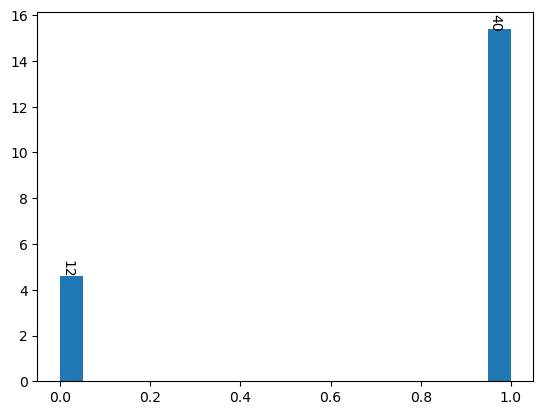

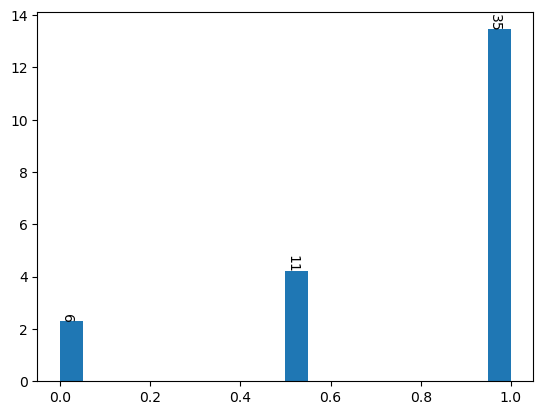

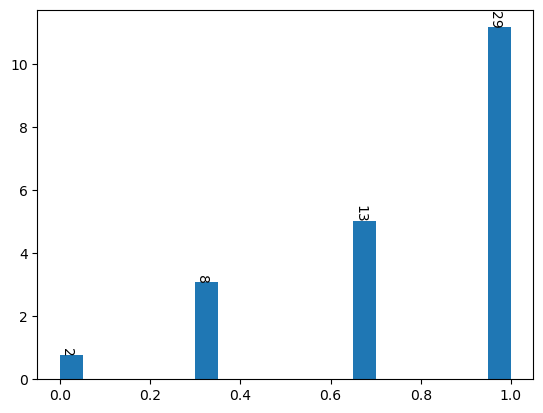

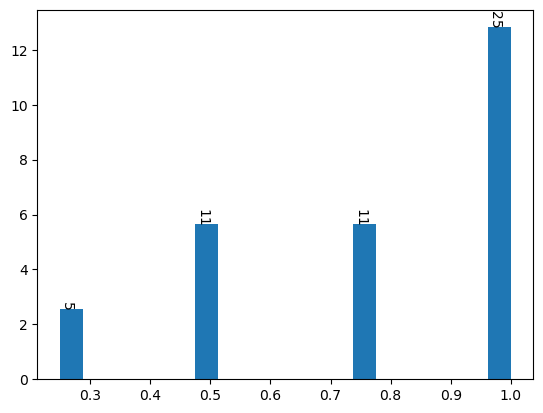

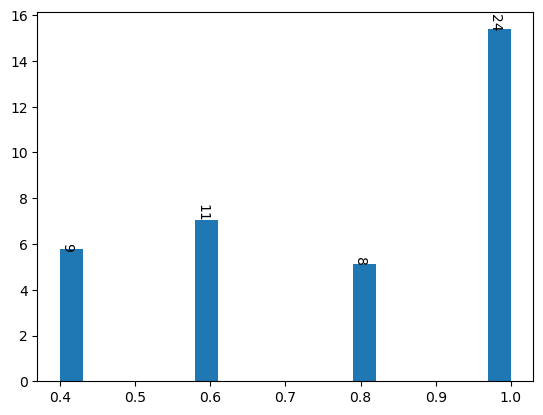

In [99]:
import numpy as np
import matplotlib.pyplot as plt

for c in df.columns:
    density, bins, _ = plt.hist(df[c], density=True, bins=20)
    count, _ = np.histogram(df[c], bins)
    for x,y,num in zip(bins, density, count):
        if num != 0:
            plt.text(x, y+0.05, num, fontsize=10, rotation=-90)
    plt.show()

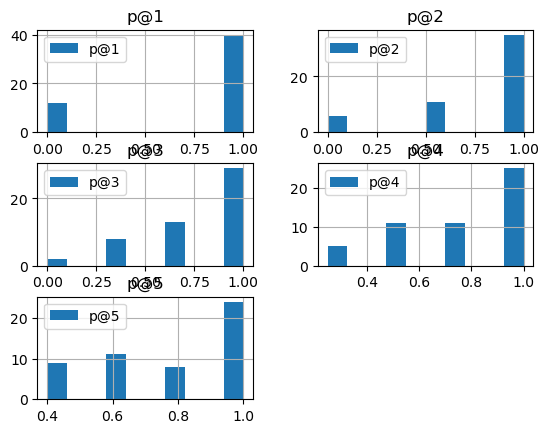

In [94]:
counts, edges, bars = df.hist()
plt.show()

In [58]:
drugCount = {}
# iterateFusionModels(basePath, trainData, trainEff, testData, testTemp)
for cell, subdf in testTemp.groupby(by='cell_line'):
    sortDF = subdf.sort_values(by='pred', ascending=False).reset_index(drop=True)
    drugs = sortDF.loc[:3, 'drug']
    for drug in drugs:
        if drug in drugCount.keys():
            drugCount[drug] += 1
        else:
            drugCount[drug] = 1
    drug = drugs[0]
        
    if sortDF.iloc[:3, :].true.sum() == 0:
        print(f"\nNo true effective drugs identified in top 3 for {cell}")
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}\n")
    else:
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}")
    


Cell line: ACH-000012; Top drug: genz-644282
Cell line: ACH-000062; Top drug: romidepsin
Cell line: ACH-000086; Top drug: YM-155

No true effective drugs identified in top 3 for ACH-000161
Cell line: ACH-000161; Top drug: echinomycin

Cell line: ACH-000164; Top drug: genz-644282
Cell line: ACH-000222; Top drug: camptothecin
Cell line: ACH-000280; Top drug: GZD824
Cell line: ACH-000305; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000316; Top drug: bruceantin
Cell line: ACH-000320; Top drug: alvespimycin
Cell line: ACH-000329; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000347; Top drug: romidepsin
Cell line: ACH-000368; Top drug: verubulin
Cell line: ACH-000376; Top drug: sangivamycin
Cell line: ACH-000421; Top drug: genz-644282
Cell line: ACH-000450; Top drug: vincristine
Cell line: ACH-000467; Top drug: maytansinol-isobutyrate
Cell line: ACH-000486; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000493; Top drug: echinomycin
Cell line: ACH-000510; Top drug: YM-155
Cell line: 

In [59]:
drugCount

{'genz-644282': 28,
 'triptolide': 7,
 'dolastatin-10': 14,
 '10-hydroxycamptothecin': 18,
 'romidepsin': 16,
 'cabazitaxel': 14,
 'PF-03758309': 4,
 'echinomycin': 16,
 'YM-155': 16,
 'alvespimycin': 10,
 'JNJ-26481585': 3,
 'camptothecin': 4,
 'maytansinol-isobutyrate': 4,
 'epothilone-b': 19,
 'GZD824': 5,
 'bruceantin': 1,
 'docetaxel': 1,
 'verubulin': 4,
 'nemorubicin': 5,
 'sangivamycin': 1,
 'epothilone-d': 1,
 'vincristine': 4,
 'gemcitabine': 4,
 'ixazomib-citrate': 1,
 'rubitecan': 2,
 'PF-477736': 1,
 'tanespimycin': 1,
 'BGT226': 2,
 'delanzomib': 1,
 'peruvoside': 1}

In [77]:
testTemp[testTemp.cell_line == 'ACH-000161'].sort_values(by='pred', ascending=False).head(10)

,cell_line,drug,true,pred
6301,ACH-000161,echinomycin,0,0.810681
6235,ACH-000161,cabazitaxel,0,0.807362
6237,ACH-000161,genz-644282,0,0.797310
6288,ACH-000161,dolastatin-10,1,0.796758
6296,ACH-000161,10-hydroxycamptothecin,1,0.796732
6231,ACH-000161,RITA,1,0.773266
6274,ACH-000161,YM-155,1,0.766606
6262,ACH-000161,JNJ-26481585,0,0.745375
6259,ACH-000161,sangivamycin,1,0.731357
6284,ACH-000161,gemcitabine,1,0.719159


Effective cutoff is 7.27

In [78]:
testCDR[(testCDR.name.isin(['echinomycin', 'cabazitaxel', 'genz-644282'])) & (testCDR.DepMap_ID == 'ACH-000161')]

,DepMap_ID,cancer_type,name,moa,target,indication,phase,r2,ic50,auc,lower_limit,effectiveCont,effective
6235,ACH-000161,Lung Cancer,cabazitaxel,microtubule inhibitor,"TUBA4A, TUBB, TUBB1",prostate cancer,Launched,0.860805,0.006491,0.383383,0.195955,6.398050,0
6237,ACH-000161,Lung Cancer,genz-644282,topoisomerase inhibitor,TOP1,NaN,Phase 1,0.842343,0.026795,0.400490,0.021216,6.892629,0
6301,ACH-000161,Lung Cancer,echinomycin,DNA intercalating agent,NaN,NaN,Phase 2,0.869458,0.007805,0.294896,0.055726,7.242270,0


In [79]:
testTemp[testTemp.cell_line == 'ACH-000750'].sort_values(by='pred', ascending=False).head()

,cell_line,drug,true,pred
4087,ACH-000750,camptothecin,0,0.821160
4198,ACH-000750,alvespimycin,0,0.802244
4082,ACH-000750,gemcitabine,0,0.795641
4093,ACH-000750,dolastatin-10,1,0.773673
4066,ACH-000750,YM-155,1,0.768075
4048,ACH-000750,genz-644282,1,0.758633
4130,ACH-000750,echinomycin,1,0.754948
4111,ACH-000750,10-hydroxycamptothecin,1,0.754500
4137,ACH-000750,nemorubicin,1,0.719455
4096,ACH-000750,OTS167,1,0.500505


In [80]:
testCDR[(testCDR.name.isin(['camptothecin', 'alvespimycin', 'gemcitabine'])) & (testCDR.DepMap_ID == 'ACH-000750')]

,DepMap_ID,cancer_type,name,moa,target,indication,phase,r2,ic50,auc,lower_limit,effectiveCont,effective
4082,ACH-000750,Skin Cancer,gemcitabine,ribonucleotide reductase inhibitor,"CMPK1, RRM1, RRM2, TYMS","ovarian cancer, breast cancer, non-small cell ...",Launched,0.759237,0.015812,0.378026,0.069460,6.324218,0
4087,ACH-000750,Skin Cancer,camptothecin,topoisomerase inhibitor,TOP1,NaN,Phase 3,0.773377,0.011412,0.329380,0.044085,7.057296,0
4198,ACH-000750,Skin Cancer,alvespimycin,HSP inhibitor,HSP90AA1,NaN,Phase 2,0.707796,0.015914,0.794836,0.161926,5.469970,0


In [81]:
# For DeepDSC
testCDR[(testCDR.name.isin(['alvespimycin', 'tanespimycin', 'ouabain'])) & (testCDR.DepMap_ID == 'ACH-000563')]

,DepMap_ID,cancer_type,name,moa,target,indication,phase,r2,ic50,auc,lower_limit,effectiveCont,effective
5526,ACH-000563,Lung Cancer,ouabain,ATPase inhibitor,ATP1A1,"hypertension, cardiac arrythmia",Launched,0.850167,0.285171,0.641032,0.022983,4.727024,0
5666,ACH-000563,Lung Cancer,tanespimycin,HSP inhibitor,HSP90AA1,NaN,Phase 3,0.797153,0.011282,0.641100,0.158702,5.867309,0
5668,ACH-000563,Lung Cancer,alvespimycin,HSP inhibitor,HSP90AA1,NaN,Phase 2,0.833715,0.008500,0.726808,0.122717,6.338409,0


## New cancer

In [127]:
bestModel = 'FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna'
df = iterateFusionModels(basePath, trainData, trainEff, newData, newTemp, modelName=bestModel)

Model: FusionFewShot_Layers2_Hidden32_DO0-0_AFrelu_LR0-001_DR0-99_DS4096_BYrna
	Precision@1: 0.8154
	Precision@2: 0.7769
	Precision@3: 0.7897
	Precision@4: 0.7885
	Precision@5: 0.7846
	Precision@10: 0.7941




In [128]:
drugCount = {}
# iterateFusionModels(basePath, trainData, trainEff, testData, testTemp)
for cell, subdf in newTemp.groupby(by='cell_line'):
    sortDF = subdf.sort_values(by='pred', ascending=False).reset_index(drop=True)
    drugs = sortDF.loc[:3, 'drug']
    for drug in drugs:
        if drug in drugCount.keys():
            drugCount[drug] += 1
        else:
            drugCount[drug] = 1
    drug = drugs[0]
        
    if sortDF.iloc[:3, :].true.sum() == 0:
        print(f"\nNo true effective drugs identified in top 3 for {cell}")
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}\n")
    else:
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}")

Cell line: ACH-000037; Top drug: echinomycin
Cell line: ACH-000046; Top drug: GZD824
Cell line: ACH-000052; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000054; Top drug: echinomycin
Cell line: ACH-000087; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000090; Top drug: cabazitaxel
Cell line: ACH-000096; Top drug: triptolide
Cell line: ACH-000099; Top drug: maytansinol-isobutyrate
Cell line: ACH-000141; Top drug: maytansinol-isobutyrate
Cell line: ACH-000159; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000169; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000171; Top drug: maytansinol-isobutyrate
Cell line: ACH-000172; Top drug: maytansinol-isobutyrate
Cell line: ACH-000174; Top drug: maytansinol-isobutyrate
Cell line: ACH-000182; Top drug: YM-155
Cell line: ACH-000189; Top drug: maytansinol-isobutyrate
Cell line: ACH-000191; Top drug: afatinib
Cell line: ACH-000201; Top drug: alvespimycin
Cell line: ACH-000209; Top drug: GZD824
Cell line: ACH-000250; Top drug: camptothecin
C

In [103]:
drugCount

{'echinomycin': 16,
 'alvespimycin': 17,
 'YM-155': 23,
 'verubulin': 10,
 'GZD824': 5,
 'epothilone-b': 17,
 'dolastatin-10': 22,
 '10-hydroxycamptothecin': 27,
 'triptolide': 7,
 'genz-644282': 35,
 'nemorubicin': 7,
 'romidepsin': 15,
 'BGT226': 3,
 'cabazitaxel': 16,
 'vincristine': 6,
 'maytansinol-isobutyrate': 12,
 'camptothecin': 4,
 'SB-743921': 2,
 'JNJ-26481585': 4,
 'afatinib': 1,
 'sangivamycin': 2,
 'epothilone-d': 2,
 'rubitecan': 2,
 'KPT-185': 1,
 'OTS167': 1,
 'talazoparib': 1,
 'gemcitabine': 2,
 'exatecan-mesylate': 1,
 'bardoxolone-methyl': 1,
 'tirapazamine': 1,
 'halofuginone': 1,
 'docetaxel': 1,
 'pyrithione-zinc': 1,
 'bruceantin': 1,
 'delanzomib': 1}

In [108]:
newTemp[newTemp.cell_line == 'ACH-000268'].sort_values(by='pred', ascending=False).head(15)

,cell_line,drug,true,pred
9846,ACH-000268,verubulin,0,0.719711
9832,ACH-000268,sangivamycin,0,0.700130
9834,ACH-000268,epothilone-d,0,0.507877
9844,ACH-000268,rubitecan,0,0.433175
9839,ACH-000268,BGT226,0,0.328325
9836,ACH-000268,SB-939,0,0.104504
9835,ACH-000268,delanzomib,0,0.066189
9843,ACH-000268,LY2606368,0,0.044299
9838,ACH-000268,GSK2126458,0,0.024082
9837,ACH-000268,alvocidib,0,0.014727


In [109]:
newTemp[newTemp.cell_line == 'ACH-000268'].true.value_counts()

0    18
1     1
Name: true, dtype: int64

In [113]:
newTemp[newTemp.cell_line == 'ACH-000428'].sort_values(by='pred', ascending=False).head(15)

,cell_line,drug,true,pred
9707,ACH-000428,JNJ-26481585,0,0.820004
9744,ACH-000428,echinomycin,0,0.795698
9692,ACH-000428,cabazitaxel,0,0.790149
9717,ACH-000428,YM-155,1,0.785368
9737,ACH-000428,10-hydroxycamptothecin,1,0.760326
9724,ACH-000428,alvespimycin,0,0.740871
9729,ACH-000428,OTS167,0,0.477448
9711,ACH-000428,peruvoside,0,0.388879
9706,ACH-000428,epothilone-d,0,0.385363
9714,ACH-000428,PF-03758309,0,0.384619


In [114]:
newTemp[newTemp.cell_line == 'ACH-000428'].true.value_counts()

0    91
1     7
Name: true, dtype: int64

In [116]:
newTemp[(newTemp.cell_line == 'ACH-000428') & (newTemp.true == 1)].sort_values(by='pred', ascending=False)

,cell_line,drug,true,pred
9717,ACH-000428,YM-155,1,7.853676e-01
9737,ACH-000428,10-hydroxycamptothecin,1,7.603259e-01
9747,ACH-000428,BGT226,1,2.424542e-02
9745,ACH-000428,dacinostat,1,8.435106e-03
9751,ACH-000428,BI-78D3,1,1.401713e-03
9743,ACH-000428,PKI-179,1,8.647728e-05
9721,ACH-000428,thonzonium,1,6.221494e-08


In [117]:
newTemp[newTemp.cell_line == 'ACH-000428'].sort_values(by='pred', ascending=False).tail(15)

,cell_line,drug,true,pred
9746,ACH-000428,tivantinib,0,7.141221e-07
9703,ACH-000428,cladribine,0,6.391586e-07
9765,ACH-000428,BMS-754807,0,2.450844e-07
9721,ACH-000428,thonzonium,1,6.221494e-08
9731,ACH-000428,EVP4593,0,4.825553e-08
9779,ACH-000428,idasanutlin,0,3.334599e-08
9696,ACH-000428,midostaurin,0,2.181120e-08
9758,ACH-000428,GSK2110183,0,9.060417e-09
9756,ACH-000428,disulfiram,0,9.019444e-09
9702,ACH-000428,pitavastatin,0,4.664209e-09


In [120]:
newTemp[newTemp.true == 1].cell_line.value_counts().tail(10)

ACH-000461    8
ACH-000428    7
ACH-000649    7
ACH-000833    6
ACH-000141    5
ACH-000516    5
ACH-000209    5
ACH-001321    5
ACH-000484    3
ACH-000268    1
Name: cell_line, dtype: int64